In [9]:
import librosa
import librosa.display
from pydub import AudioSegment

import cv2
import os

import numpy as np
import matplotlib.pyplot as plt
cv2.__version__

'4.5.5'

In [10]:
librosa.__version__

'0.9.1'

In [ ]:
# !ffmpeg -i Tea_witch_SFA(Audio).mp3 Tears_of_a_witch_SFA.wav

In [36]:
'''
테스트 배열 생성
y, sr = librosa.load('Tears_of_a_witch_SFA.wav',sr=None, offset=0, duration=10)
print(y.shape, sr)
np.savez('test.npz',sig=y)
'''

(441000,) 44100


In [37]:
y = np.load('test.npz')['sig']
print(y.shape)

(441000,)


In [13]:
onset_env = librosa.onset.onset_strength(y=y, sr=sr)

# Run the default beat tracker
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
print('Estimated tempo: {:.2f} beats per minute'.format(tempo))
print(beat_frames.shape)

# dynamic tempo
dtempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr,
                            aggregate=None)

# Convert the frame indices of beat events into timestamps
beat_times = librosa.frames_to_time(beat_frames, sr=sr)
print(beat_times.shape)
print(dtempo.shape)

Estimated tempo: 79.51 beats per minute
(12,)
(12,)
(862,)


In [79]:
hop_len = 512
freq_w = 3
octave = 8

C = librosa.cqt(y, sr=sr, hop_length= hop_len, n_bins= 12*freq_w*octave, bins_per_octave= 12*freq_w)
C.shape

(288, 862)

In [80]:
C_db = librosa.amplitude_to_db(np.abs(C), ref=np.max)+80
print(C_db.min(), C_db.max())

0.0 80.0


In [81]:
c_compression = C_db/80*255
print(c_compression.min(),c_compression.max())

0.0 255.0


In [83]:
src = c_compression

gaussian_mask = np.array([[1/16,1/8,1/16], [1/8,1/4,1/8], [1/16,1/8,1/16]])
sharpening_mask1 = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
sharpening_mask2 = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

gaussian_out = cv2.filter2D(src, -1, gaussian_mask)
sharpening_out1 = cv2.filter2D(src, -1, sharpening_mask1)
sharpening_out2 = cv2.filter2D(src, -1, sharpening_mask2)

In [89]:
c_25under0 = np.where(gaussian_out<25,0,gaussian_out)

c_50under0 = np.where(gaussian_out<50,0,gaussian_out)
print(c_stretching_pre.min(), c_stretching_pre.max())

c_stretching = np.where((c_stretching_pre-155)/100*255<0,0,(c_stretching_pre-155)/100*255)
print(c_stretching.min(), c_stretching.max())

c_gray = c_stretching.astype(np.uint8)
print(c_gray.max(),c_gray.min())

0.0 255.0
0.0 255.0
255 0


In [84]:
gaussian_out.shape

(288, 862)

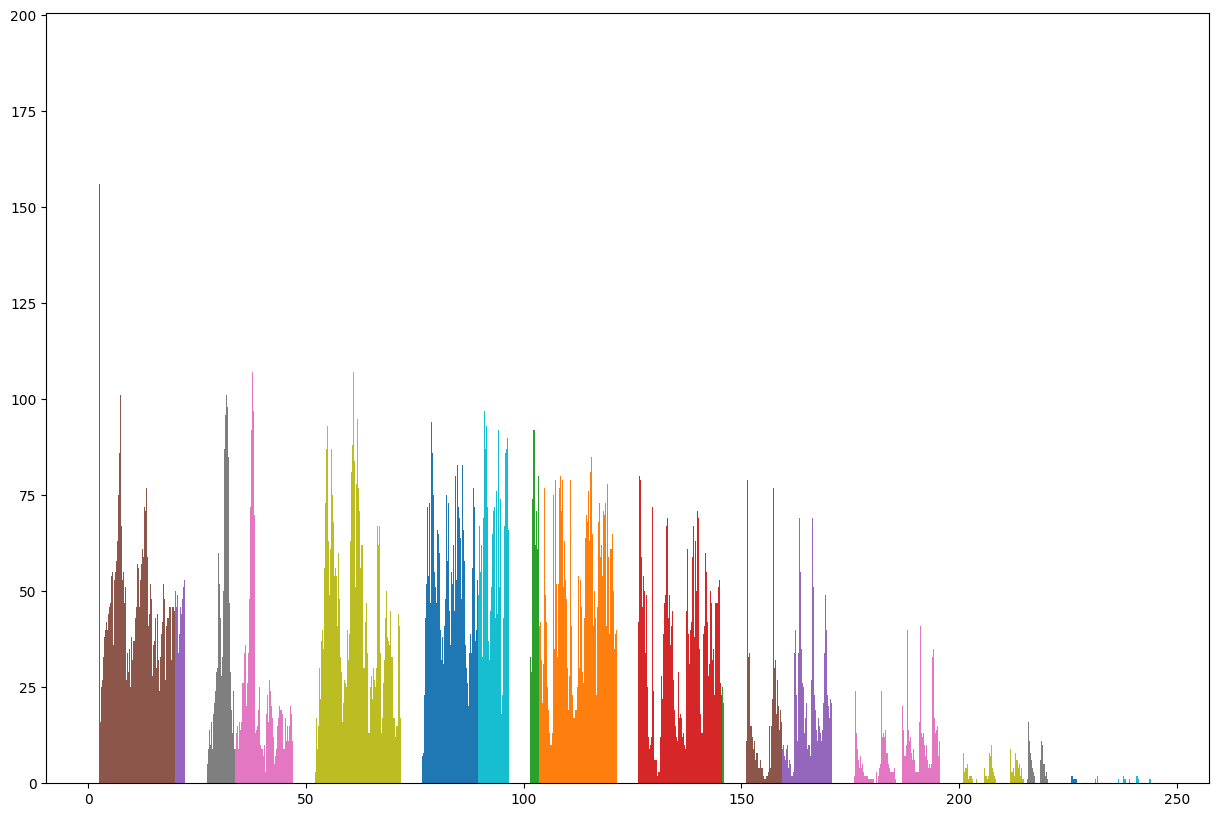

In [85]:
src = gaussian_out

plt.figure(figsize=(15,10))
plt.hist(src)
plt.show()

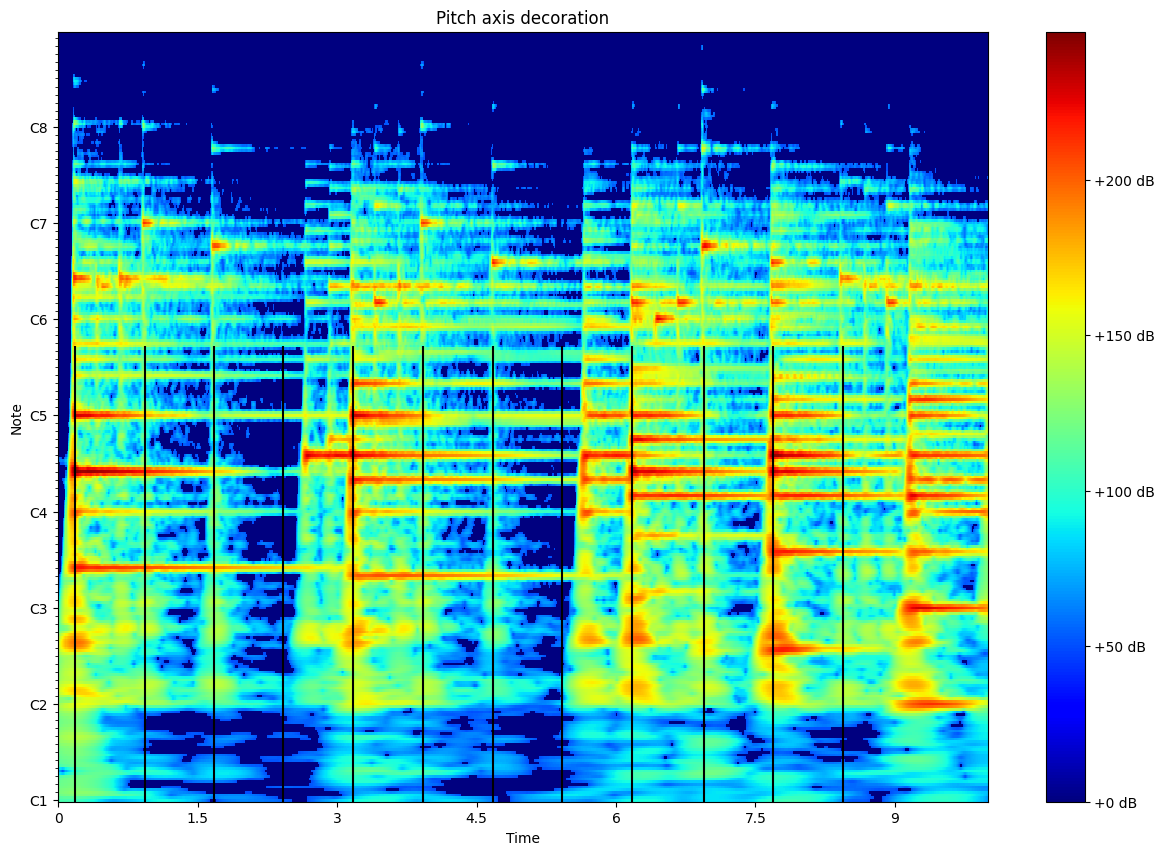

In [93]:
src = c_50under0

plt.style.use('default')
fig, ax = plt.subplots(1,1,figsize=(15,10))
img = librosa.display.specshow(src, sr=sr, y_axis='cqt_note', x_axis='time', ax=ax, hop_length= hop_len, bins_per_octave= 12*freq_w,
                               cmap='jet'
                               )
ax.set(title='Pitch axis decoration')
fig.colorbar(img, ax=ax, format="%+2d dB")
ax.vlines(beat_times,0,C.shape[1],colors='k')

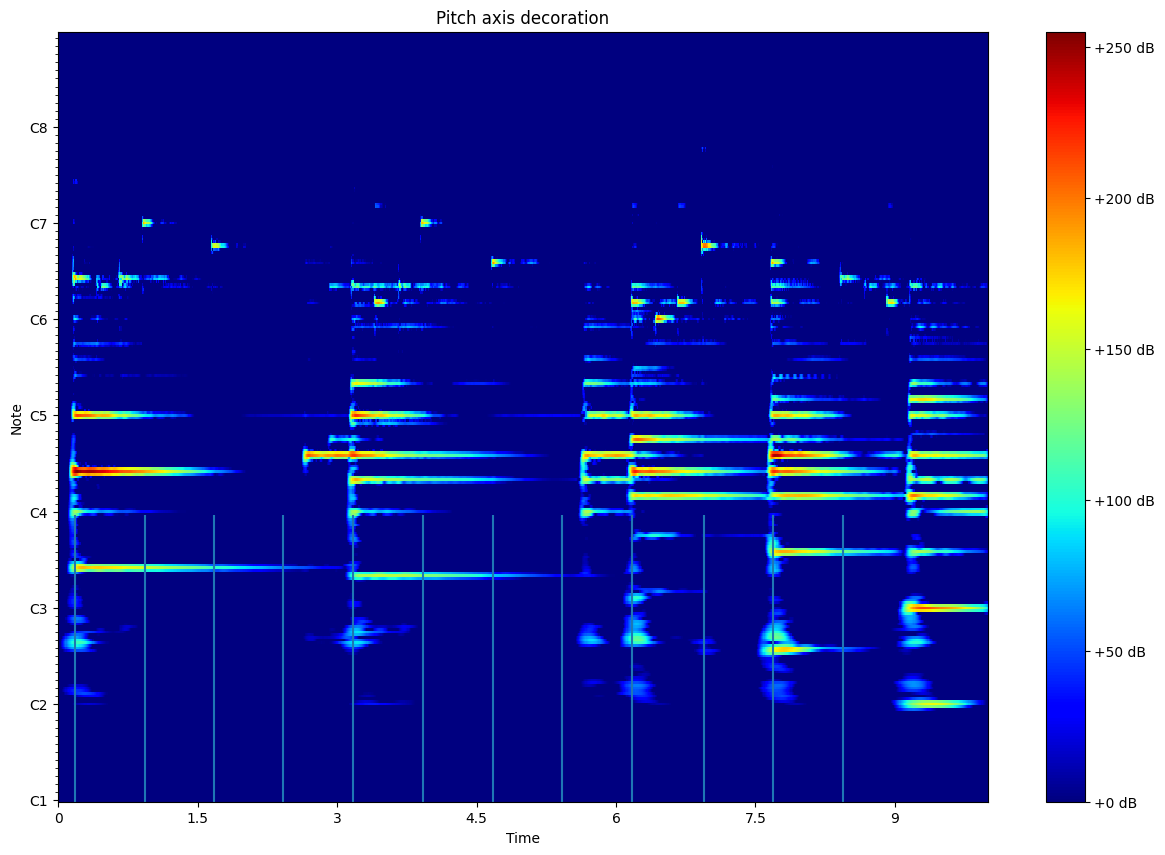

In [87]:
c_y = c_gray

fig, ax = plt.subplots(1,1,figsize=(15,10))
img = librosa.display.specshow(c_y, sr=sr, y_axis='cqt_note', x_axis='time', ax=ax, hop_length= hop_len, bins_per_octave= 12*freq_w, cmap='jet')
ax.set(title='Pitch axis decoration')
ax.vlines(beat_times,0,255)
fig.colorbar(img, ax=ax, format="%+2d dB")

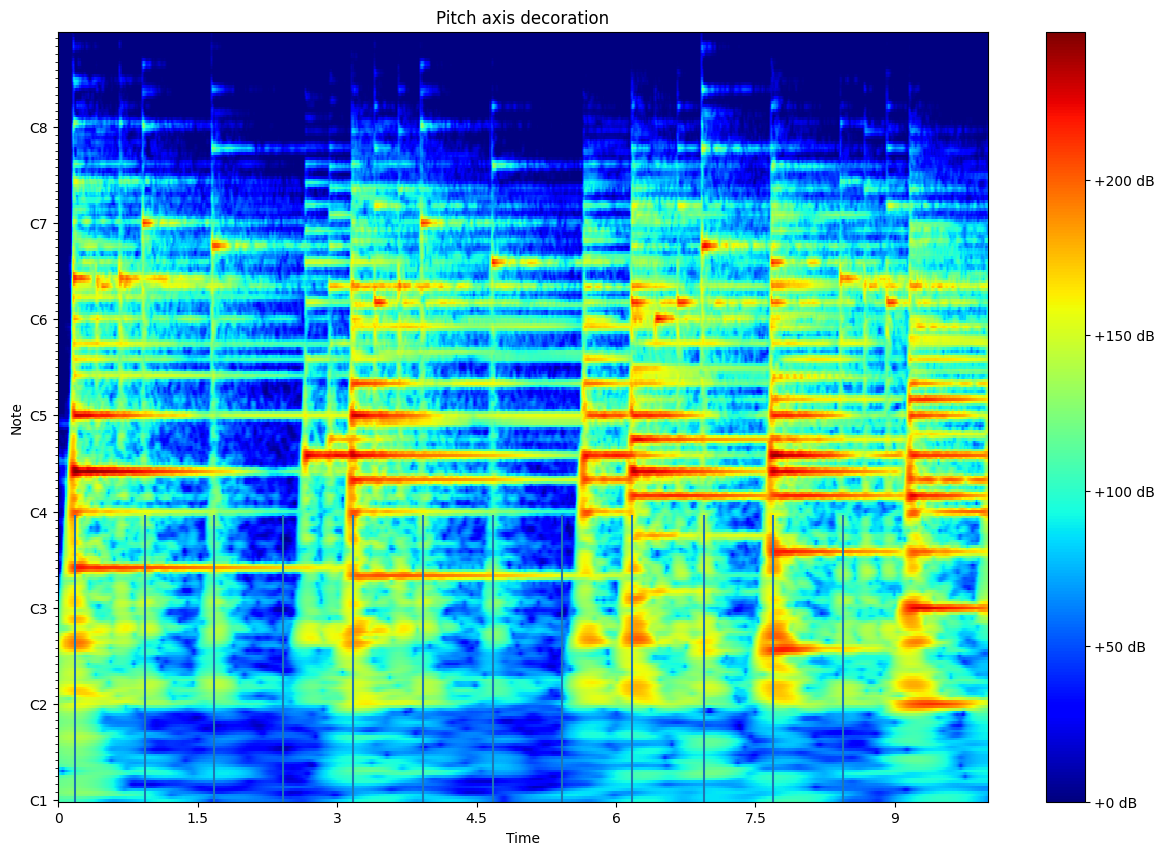

In [88]:
c_y = gaussian_out

fig, ax = plt.subplots(1,1,figsize=(15,10))
img = librosa.display.specshow(c_y, sr=sr, y_axis='cqt_note', x_axis='time', ax=ax, hop_length= hop_len, bins_per_octave= 12*freq_w, cmap='jet')
ax.set(title='Pitch axis decoration')
ax.vlines(beat_times,0,255)
fig.colorbar(img, ax=ax, format="%+2d dB")

# ax[1].scatter(beat_times,dtempo)
# ax[1].set_xlim(0,5)